In [1]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torchvision.models as models

In [2]:
batch_size_train = 100
batch_size_test = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
class Resnet34(nn.Module):
    def __init__(self):
        super(Resnet34, self).__init__() # Load pre-trained ResNet50 model
        self.resnet = models.resnet34(pretrained=False) # Modify the last layer for our classification task
        self.resnet.conv1 = torch.nn.Conv2d(1, 64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3), bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)
    def forward(self, x):
        x = self.resnet(x)
        return x

In [6]:
model = Resnet34().cuda()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Resnet34(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [7]:
test_loss_min = np.Inf
LR=5e-4
optimizer = optim.Adam(model.parameters(), lr=LR)
test_acc_max = -100
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(model.parameters(), lr=LR)

    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min, test_loss))
        torch.save(model.state_dict(), 'MNIST_Normal_MLP_leastLoss.pt')
        test_loss_min = test_loss
    if test_acc >= test_acc_max:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max, test_acc))
        torch.save(model.state_dict(), 'MNIST_Normal_MLP_Most_Accuracy.pt')
        test_acc_max = test_acc
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.162365 - Testing Loss: 0.064965 - Training Accuracy: 94.86% - Testing Accuracy: 97.98%
Testing loss decreased (inf --> 0.064965). The new model saved.
Testing Acc increased (-100.000000 --> 97.980000). The new model saved.
Epoch 2 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.060239 - Testing Loss: 0.050234 - Training Accuracy: 98.25% - Testing Accuracy: 98.38%
Testing loss decreased (0.064965 --> 0.050234). The new model saved.
Testing Acc increased (97.980000 --> 98.380000). The new model saved.
Epoch 3 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.045118 - Testing Loss: 0.056300 - Training Accuracy: 98.63% - Testing Accuracy: 98.43%
Testing Acc increased (98.380000 --> 98.430000). The new model saved.
Epoch 4 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.035008 - Testing Loss: 0.037924 - Training Accuracy: 98.97% - Testing Accuracy: 98.91%
Testing loss decreased (0.050234 --> 0.037924). The new model saved.
Testing Acc increased (98.430000 --> 98.910000). The new model saved.
Epoch 5 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.044771 - Testing Loss: 0.046115 - Training Accuracy: 98.68% - Testing Accuracy: 98.58%
Epoch 6 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.030820 - Testing Loss: 0.038983 - Training Accuracy: 99.09% - Testing Accuracy: 98.84%
Epoch 7 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.023356 - Testing Loss: 0.035892 - Training Accuracy: 99.33% - Testing Accuracy: 98.98%
Testing loss decreased (0.037924 --> 0.035892). The new model saved.
Testing Acc increased (98.910000 --> 98.980000). The new model saved.
Epoch 8 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.021603 - Testing Loss: 0.037629 - Training Accuracy: 99.34% - Testing Accuracy: 98.85%
Epoch 9 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.018516 - Testing Loss: 0.082413 - Training Accuracy: 99.43% - Testing Accuracy: 98.05%


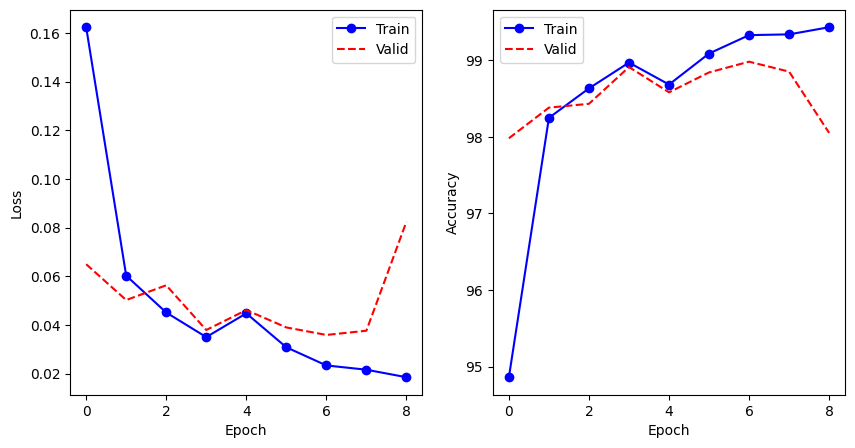

In [8]:
import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [9]:
modelSynScaL = Resnet34().cuda()
test_loss_min_SynScaL = np.Inf
LR=5e-4
optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)
test_acc_max_SynScaL = -100
historySynScaL = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)

    modelSynScaL.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target)+ 1.0 * (0.1 - output.mean())**2
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    modelSynScaL.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target) +  1.0 * (0.1 - output.mean())**2
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaL:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaL, test_loss))
        torch.save(modelSynScaL.state_dict(), 'MNIST_SynScaL_MLP_leastLoss.pt')
        test_loss_min_SynScaL = test_loss
    if test_acc >= test_acc_max_SynScaL:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaL, test_acc))
        torch.save(modelSynScaL.state_dict(), 'MNIST_SynScaL_MLP_Most_Accuracy.pt')
        test_acc_max_SynScaL = test_acc
    historySynScaL['train_loss'].append(train_loss)
    historySynScaL['valid_loss'].append(test_loss)
    historySynScaL['train_acc'].append(train_acc)
    historySynScaL['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.163419 - Testing Loss: 0.084721 - Training Accuracy: 94.98% - Testing Accuracy: 97.63%
Testing loss decreased (inf --> 0.084721). The new model saved.
Testing Acc increased (-100.000000 --> 97.630000). The new model saved.
Epoch 2 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.062492 - Testing Loss: 0.066563 - Training Accuracy: 98.17% - Testing Accuracy: 98.17%
Testing loss decreased (0.084721 --> 0.066563). The new model saved.
Testing Acc increased (97.630000 --> 98.170000). The new model saved.
Epoch 3 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.045182 - Testing Loss: 0.046520 - Training Accuracy: 98.64% - Testing Accuracy: 98.71%
Testing loss decreased (0.066563 --> 0.046520). The new model saved.
Testing Acc increased (98.170000 --> 98.710000). The new model saved.
Epoch 4 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.037495 - Testing Loss: 0.039699 - Training Accuracy: 98.83% - Testing Accuracy: 98.86%
Testing loss decreased (0.046520 --> 0.039699). The new model saved.
Testing Acc increased (98.710000 --> 98.860000). The new model saved.
Epoch 5 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.046320 - Testing Loss: 0.064834 - Training Accuracy: 98.63% - Testing Accuracy: 98.14%
Epoch 6 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.029534 - Testing Loss: 0.053552 - Training Accuracy: 99.13% - Testing Accuracy: 98.48%
Epoch 7 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.025896 - Testing Loss: 0.038236 - Training Accuracy: 99.20% - Testing Accuracy: 99.03%
Testing loss decreased (0.039699 --> 0.038236). The new model saved.
Testing Acc increased (98.860000 --> 99.030000). The new model saved.
Epoch 8 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.021671 - Testing Loss: 0.029513 - Training Accuracy: 99.38% - Testing Accuracy: 99.10%
Testing loss decreased (0.038236 --> 0.029513). The new model saved.
Testing Acc increased (99.030000 --> 99.100000). The new model saved.
Epoch 9 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.015127 - Testing Loss: 0.044710 - Training Accuracy: 99.55% - Testing Accuracy: 98.76%


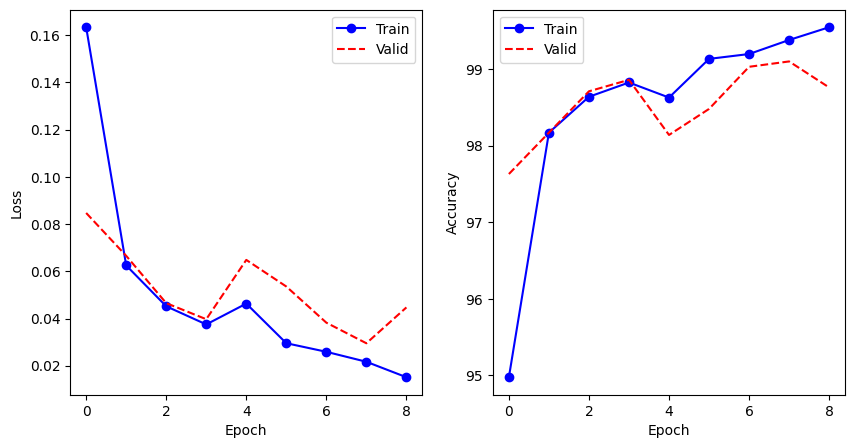

In [10]:
fig=plt.figure(1,figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(historySynScaL['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaL['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [11]:
def update_param(parameter_data, activation, gamma=0.1,mean = 0.1):
    activation = activation.data.numpy().mean(axis=(0)).squeeze()[:,None]
    param = parameter_data.numpy()
    new_param = param+gamma*np.clip((param*param)*(mean - activation).mean(),-1,1)
    return torch.from_numpy(new_param)
def perform_update(m):
    if type(m) == nn.Linear:
        m.eval()
        im = np.random.uniform(-1, 1, (100, m.in_features))+0.1
        im_as_ten = torch.from_numpy(im).float().cuda()
        x = Variable(im_as_ten, requires_grad=True)
        x = F.relu(m(x))
        m.weight.data = update_param(m.weight.data.cpu(),activation=x.cpu()).cuda()
    if type(m) == nn.Conv2d:
        m.eval()
        im = np.random.uniform(-1, 1, (100, m.weight.size()[1],28,28))+0.1
        im_as_ten = torch.from_numpy(im).float().cuda()
        x = Variable(im_as_ten, requires_grad=True)
        x = F.relu(m(x))
        m.weight.data = update_param(m.weight.data.cpu(),activation=x.cpu()).cuda()

In [12]:
modelSynScaW = Resnet34().cuda()
test_loss_min_SynScaW= np.Inf
test_acc_max_SynScaW = -100
LR=5e-4
optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)
historySynScaW = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 10):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)

    modelSynScaW.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    modelSynScaW.apply(perform_update)
    #validate
    modelSynScaW.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaW:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaW, test_loss))
        torch.save(modelSynScaW.state_dict(), 'MNIST_SynScaW_MLP_leastLoss.pt')
        test_loss_min_SynScaW = test_loss
    if test_acc >= test_acc_max_SynScaW:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaW, test_acc))
        torch.save(modelSynScaW.state_dict(), 'MNIST_SynScaW_MLP_Most_Accuracy.pt')
        test_acc_max_SynScaW = test_acc
    historySynScaW['train_loss'].append(train_loss)
    historySynScaW['valid_loss'].append(test_loss)
    historySynScaW['train_acc'].append(train_acc)
    historySynScaW['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.154562 - Testing Loss: 0.111155 - Training Accuracy: 95.17% - Testing Accuracy: 96.55%
Testing loss decreased (inf --> 0.111155). The new model saved.
Testing Acc increased (-100.000000 --> 96.550000). The new model saved.
Epoch 2 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.061486 - Testing Loss: 0.053559 - Training Accuracy: 98.14% - Testing Accuracy: 98.29%
Testing loss decreased (0.111155 --> 0.053559). The new model saved.
Testing Acc increased (96.550000 --> 98.290000). The new model saved.
Epoch 3 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.042884 - Testing Loss: 0.052586 - Training Accuracy: 98.67% - Testing Accuracy: 98.40%
Testing loss decreased (0.053559 --> 0.052586). The new model saved.
Testing Acc increased (98.290000 --> 98.400000). The new model saved.
Epoch 4 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.036357 - Testing Loss: 0.037623 - Training Accuracy: 98.89% - Testing Accuracy: 98.84%
Testing loss decreased (0.052586 --> 0.037623). The new model saved.
Testing Acc increased (98.400000 --> 98.840000). The new model saved.
Epoch 5 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.044456 - Testing Loss: 0.060194 - Training Accuracy: 98.67% - Testing Accuracy: 98.33%
Epoch 6 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.029212 - Testing Loss: 0.033546 - Training Accuracy: 99.16% - Testing Accuracy: 99.11%
Testing loss decreased (0.037623 --> 0.033546). The new model saved.
Testing Acc increased (98.840000 --> 99.110000). The new model saved.
Epoch 7 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.024526 - Testing Loss: 0.035441 - Training Accuracy: 99.26% - Testing Accuracy: 98.92%
Epoch 8 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.021430 - Testing Loss: 0.035086 - Training Accuracy: 99.35% - Testing Accuracy: 98.92%
Epoch 9 ...


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.017385 - Testing Loss: 0.046223 - Training Accuracy: 99.47% - Testing Accuracy: 98.91%


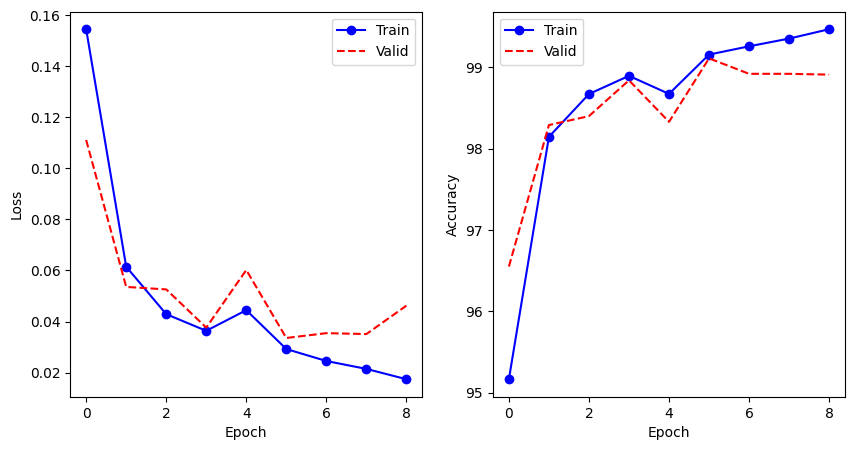

In [13]:

import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(historySynScaW['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaW['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
from tabulate import tabulate
data = [['Loss', test_loss_min, test_loss_min_SynScaL, test_loss_min_SynScaW],
['Accuracy', test_acc_max, test_acc_max_SynScaL, test_acc_max_SynScaW],
]
print (tabulate(data, headers=["Type", "Normal", "SynScaL", "SynScaW"]))

Type          Normal     SynScaL     SynScaW
--------  ----------  ----------  ----------
Loss       0.0358917   0.0295132   0.0335459
Accuracy  98.98       99.1        99.11
